In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import transforms
import data
from model.unet import U_Net
from model.simple_unet import Simple_Unet
import matplotlib.pyplot as plt
import torch
from torchsummary import summary
import glob
from sklearn.model_selection import train_test_split

/Users/maochenhui/miniforge3/envs/DL/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# model = U_Net()
model = Simple_Unet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (3, 2302, 1632))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 9, 1152, 832]             252
       BatchNorm2d-2         [-1, 9, 1152, 832]              18
              ReLU-3         [-1, 9, 1152, 832]               0
            Conv2d-4         [-1, 9, 1152, 832]             738
       BatchNorm2d-5         [-1, 9, 1152, 832]              18
              ReLU-6         [-1, 9, 1152, 832]               0
        conv_block-7         [-1, 9, 1152, 832]               0
            Conv2d-8         [-1, 12, 576, 416]             984
       BatchNorm2d-9         [-1, 12, 576, 416]              24
             ReLU-10         [-1, 12, 576, 416]               0
           Conv2d-11         [-1, 12, 576, 416]           1,308
      BatchNorm2d-12         [-1, 12, 576, 416]              24
             ReLU-13         [-1, 12, 576, 416]               0
       conv_block-14         [-1, 12, 5

In [3]:
SCANS_DIR = "input/scans/scans/"
TRUTH_DIR = "input/ground-truth-pixel/ground-truth-pixel/"
scan_files = glob.glob(SCANS_DIR+'*.png')
scan_files = sorted(scan_files)
# scan_files = list(filter(lambda x:"(" not in x, scan_files))
scan_files_dev = scan_files[:400]

scan_files_test = scan_files[400:]
truth_files = glob.glob(TRUTH_DIR+'*.png')
truth_files = sorted(truth_files)
# truth_files = list(filter(lambda x:"(" not in x, truth_files))

scan_files_train, scan_files_val, truth_files_train, truth_files_val = train_test_split(scan_files_dev, truth_files, test_size=0.3)

In [7]:
from torch.utils.data import DataLoader
train_data = data.CustomDataset(scans = scan_files_train, ground_truth=truth_files_train, transforms=transforms.default_transform["train"])
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

val_data = data.CustomDataset(scans=scan_files_val, ground_truth=truth_files_val, transforms=transforms.default_transform["val"])
val_loader = DataLoader(val_data, batch_size=1)

test_data = data.TestDataset(scans=scan_files_val)
test_loader = DataLoader(test_data, batch_size=1)

In [8]:
from train import Trainer

train = (scan_files_train, truth_files_train)
val = (scan_files_val, truth_files_val)
trainer = Trainer(train, val, model, batch_size=1, epochs=100, lr=1e-2, step_size=100)

Initialize conv
Initialize Bathch
Initialize conv
Initialize Bathch
Initialize conv
Initialize Bathch
Initialize conv
Initialize Bathch
Initialize conv
Initialize Bathch
Initialize conv
Initialize Bathch
Initialize conv
Initialize Bathch
Initialize conv
Initialize Bathch
Initialize conv
Initialize Bathch


In [6]:
trainer()

Start Training
At epoch: 0


  1%|▌                                          | 4/280 [00:09<10:59,  2.39s/it]


KeyboardInterrupt: 

In [9]:
demo = next(iter(train_loader))
out = model(demo[0].float())
out = out.reshape(out.shape[0], -1)
out.shape

torch.Size([1, 3756864])

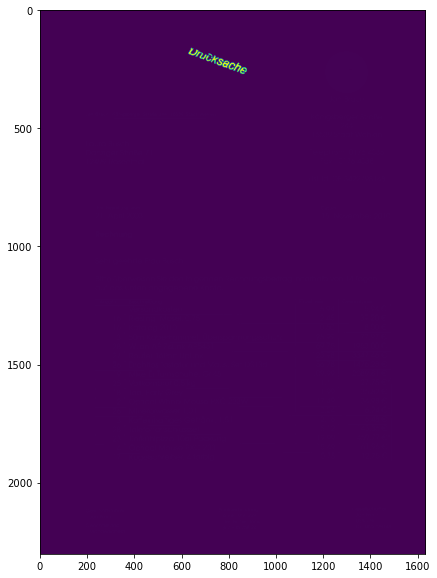

In [13]:
plt.figure(figsize=(12,10))
y = demo[2].reshape((2302, 1632)).detach().cpu()
plt.imshow(y)

In [17]:
from collections import Counter
Counter(y.numpy().reshape(-1))

Counter({1.0810220387426772: 3475289,
         1935.5301391035548: 3882,
         13.528839401785424: 277693})

In [9]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=demo[2])
# criterion = torch.nn.BCELoss()
criterion(out, demo[1].float())

tensor(1.7946, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)